# Visible Watermark Information Classification

## Prototype (YOLOv8)

This notebook is a prototype for training a YOLOv8 model using custom data.  More specifically, images that have been watermarked and annotated in Roboflow will be loaded and used in the pipeline.

The custom `RoboflowYOLOv8Loader` is required to load and transform data exported from Roboflow into the format and data structures required to use object detection in Tensorflow and train a YOLOv8 Model.

In [1]:
import os
import typing

import keras
import keras_cv
import tensorflow as tf
import tqdm

# Also possible to use jax or pytorch.
os.environ["KERAS_BACKEND"] = "tensorflow"

# Objects/Information we are trying to detect.
# numerical representation is based on list index.
CLASS_IDS = [
    "contact",  # contact information
    "identifier",  # image identifier
    "logo",  # a company logo
    "notice",  # copyright or other type of notice
]

DATA_DIR = "./visible-watermark-classification/"

BOUNDING_BOX_FORMAT = "xyxy"

BATCH_SIZE = 4

class RoboflowYOLOv8Loader:
    """RoboflowYOLOv8Loader is a custom data loader that can be used to load
    datasets that are exported from Roboflow in YOLO v8 format.
    """

    class_mapping: dict
    data_dir: str
    batch_size: int = 4

    def __init__(self, class_list: list, data_dir: str, batch_size: int = 4) -> None:
        """constructor for the custom data loader.
        Args:
            class_mapping (dict): classes and numerical representation.
            data_dir (str): top level data directory assuming structure below.
                ├── test
                │   ├── images
                │   └── labels
                ├── train
                │   ├── images
                │   └── labels
                └── valid
                    ├── images
                    └── labels
        """
        assert len(class_list) > 0, "Class list must be greater than 0."

        self.class_mapping = dict(zip(range(len(class_list)), class_list))
        self.data_dir = data_dir
        self.batch_size = batch_size

    def load_dataset(
        self, name: str | None = None
    ) -> tf.data.Dataset | typing.Tuple[tf.data.Dataset]:
        """load_dataset will load a full dataset or a specific split if desired.

        Args:
            name (str | None, optional): split name (train, valid, test).
                    Defaults to None, which will load all 3.

        Returns:
            tf.data.Dataset | typing.Tuple[tf.data.Dataset]: one or a tuple
                of datasets in the following order (train, valid, test).
        """
        if name:
            return self.__load_dataset(name)
        else:
            # load all 3
            train = self.__load_dataset("train", shuffle=True)
            val = self.__load_dataset("valid")
            test = self.__load_dataset("test")
            return (train, val, test)

    def __load_dataset(self, name: str, shuffle: bool = False) -> tf.data.Dataset:
        """__load_dataset is a private function
        that will load one specific split of a dataset
        given the name. (train, valid, test).

        Args:
            name (str): dataset split name (train, valid, test)

        Returns:
            tf.data.Dataset: the tensorflow dataset.
        """
        # validate inputs
        VALID_NAMES = ["train", "valid", "test"]
        assert name.lower() in VALID_NAMES, "name must be one of: " + str(VALID_NAMES)

        # define image and label paths
        split_path = f"{self.data_dir}/{name.lower()}"
        image_dir = f"{split_path}/images"
        label_path = f"{split_path}/labels"
        image_paths = sorted(
            [
                os.path.join(image_dir, f)
                for f in os.listdir(image_dir)
                if f.endswith(".jpg")
            ]
        )
        label_paths = sorted(
            [
                os.path.join(label_path, f)
                for f in os.listdir(label_path)
                if f.endswith(".txt")
            ]
        )

        # load images and data using yolo v8 labels.
        bbox = []
        classes = []
        for label in tqdm.tqdm(label_paths):
            boxes, class_ids = RoboflowYOLOv8Loader.parse_yolo_label(label)
            bbox.append(boxes)
            classes.append(class_ids)

        assert (
            len(image_paths) == len(bbox) == len(classes)
        ), "inputs must be the same length on the first dimension."

        # can contain lists of varying lengths, so its recommended to use ragged tensors.
        bbox = tf.ragged.constant(bbox)
        classes = tf.ragged.constant(classes)
        image_paths = tf.ragged.constant(image_paths)

        # load into tf dataset and process into standard structure.
        dataset = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))
        dataset = dataset.map(
            RoboflowYOLOv8Loader.to_dataset_dict, num_parallel_calls=tf.data.AUTOTUNE
        )
        if shuffle:
            dataset = dataset.shuffle(self.batch_size * 4)
        dataset = dataset.ragged_batch(self.batch_size, drop_remainder=True)
        return dataset

    @staticmethod
    def load_image(image_path: str) -> tf.Tensor:
        """the image in tensor format"""
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize_with_pad(image, 640, 640)
        return image

    @staticmethod
    def to_dataset_dict(
        image_path: str, classes: tf.RaggedTensor, bbox: tf.RaggedTensor
    ) -> dict:
        """data loaded in standard pipeline format:
        {
            "images": Tensor(),
            "bounding_boxes": {
                "classes": Tensor(),
                "boxes": RaggedTensor()
            }
        }
        Reference: https://keras.io/examples/vision/yolov8/

        Args:
            image_path (str): path to image
            classes (tf.RaggedTensor): classes in the image
            bbox (tf.RaggedTensor): bounding boxes in the image

        Returns:
            dict: standard tf pipeline format
        """
        image = RoboflowYOLOv8Loader.load_image(image_path)
        bounding_boxes = {
            "classes": tf.cast(classes, dtype=tf.float32),
            "boxes": bbox,
        }
        return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

    @staticmethod
    def parse_yolo_label(
        label_path: str, image_width: int = 640, image_height: int = 640
    ) -> typing.Tuple[list]:
        """parse_yolo_label will read an input txt file in the yolov8 format
        (center_xywh) and return it in xmin, ymin, xmax, ymax (Pascal VOC format).

        Args:
            label_path (str): path to label file.
            image_width (int, optional). Defaults to 640.
            image_height (int, optional). Defaults to 640.

        Returns:
            typing.Tuple[list]: boxes, class_ids
        """
        with open(label_path, "r") as f:
            lines = f.readlines()

        boxes = []
        class_ids = []

        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])

            # YOLOv8 bounding box in [x_center, y_center, width, height]
            x_center, y_center, width, height = parts[1:]

            # Convert center_xywh to xmin, ymin, xmax, ymax (Pascal VOC format)
            xmin = (float(x_center) - float(width) / 2) * image_width
            ymin = (float(y_center) - float(height) / 2) * image_height
            xmax = (float(x_center) + float(width) / 2) * image_width
            ymax = (float(y_center) + float(height) / 2) * image_height

            boxes.append([xmin, ymin, xmax, ymax])
            class_ids.append(class_id)

        return boxes, class_ids


def visualize_dataset(
    inputs: dict,
    class_mapping: dict,
    value_range: typing.Tuple,
    rows: int,
    cols: int,
    bounding_box_format: str,
    count=1,
):
    """visualize_dataset will plot images and bounding boxes
    for an input dataset.

    Args:
        inputs (dict): images and bounding boxes in standard tf format.
        class_mapping (dict): class number to name mapping.
        value_range (typing.Tuple): value range in images.
        rows (int): number of rows to display.
        cols (int): number of columns to display.
        bounding_box_format (str): format of the bounding boxes.
        count (int, optional): how many samples to plot. Defaults to 1.
    Reference: https://keras.io/examples/vision/yolov8/
    """
    inputs = next(iter(inputs.take(count)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]

    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

2025-01-18 13:19:10.857303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737224350.893046  160375 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737224350.912077  160375 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-18 13:19:10.941171: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/gb/FinalProject/prototype/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please 

## Load the visual watermark detection data

The `RoboflowYOLOv8Loader` is then used to load and split the data into different sets required in the pipeline.

In [2]:
# construct custom dataset loader.
data_loader = RoboflowYOLOv8Loader(CLASS_IDS, DATA_DIR)

# load dataset.
# split percentage is managed by Roboflow and exported.
train, val, test = data_loader.load_dataset()

100%|██████████| 35/35 [00:00<00:00, 13897.63it/s]
I0000 00:00:1737224354.277009  160375 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6061 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5
100%|██████████| 5/5 [00:00<00:00, 3007.96it/s]


## Visualize the training data

The annotated training data is visualized below to verify that the custom loader has loaded and transformed the data, and that the bounding boxes are in the correct format and are accurate.  This is critical to ensuring the object detector has accurate data when training.  The validation data is also visualized to ensure that it is correct as well.  If the validation data was incorrect then model tuning would not work well because the metrics used to tune the model during training would be incorrect.

TRAINING DATA
VALIDATION DATA


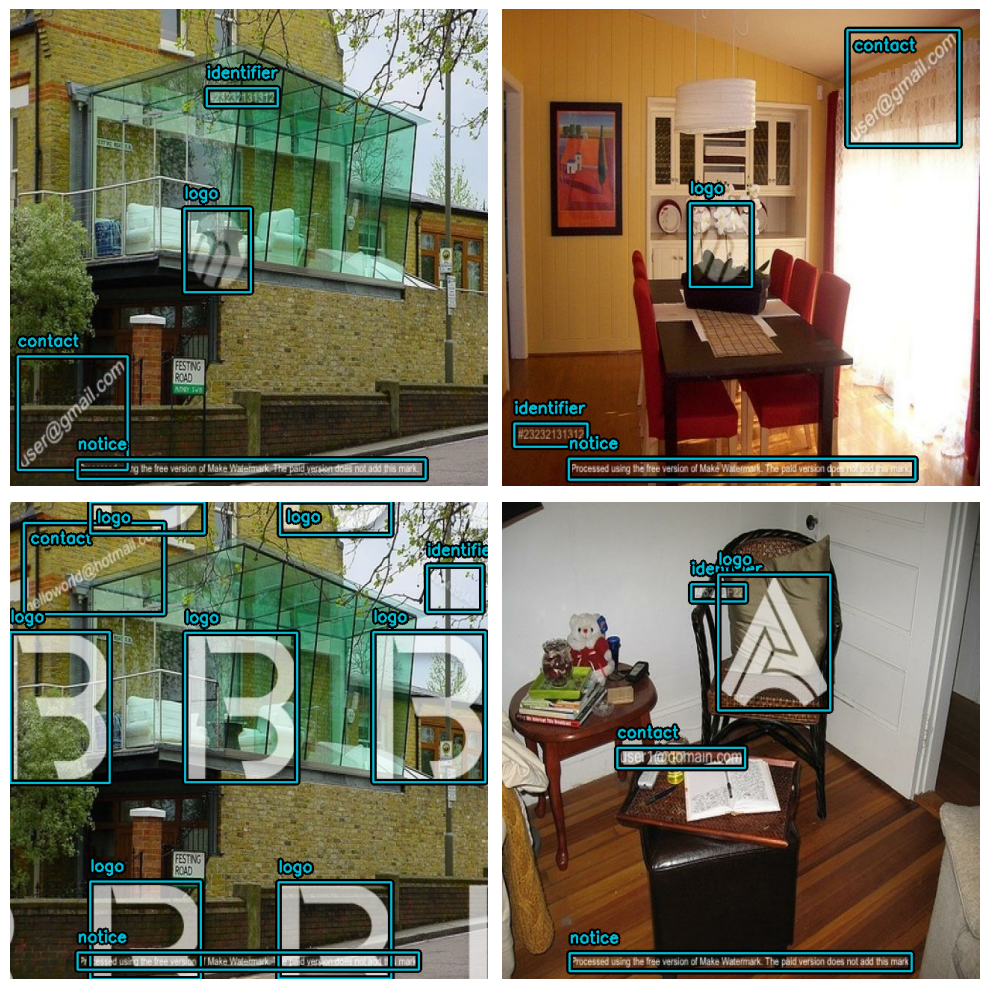

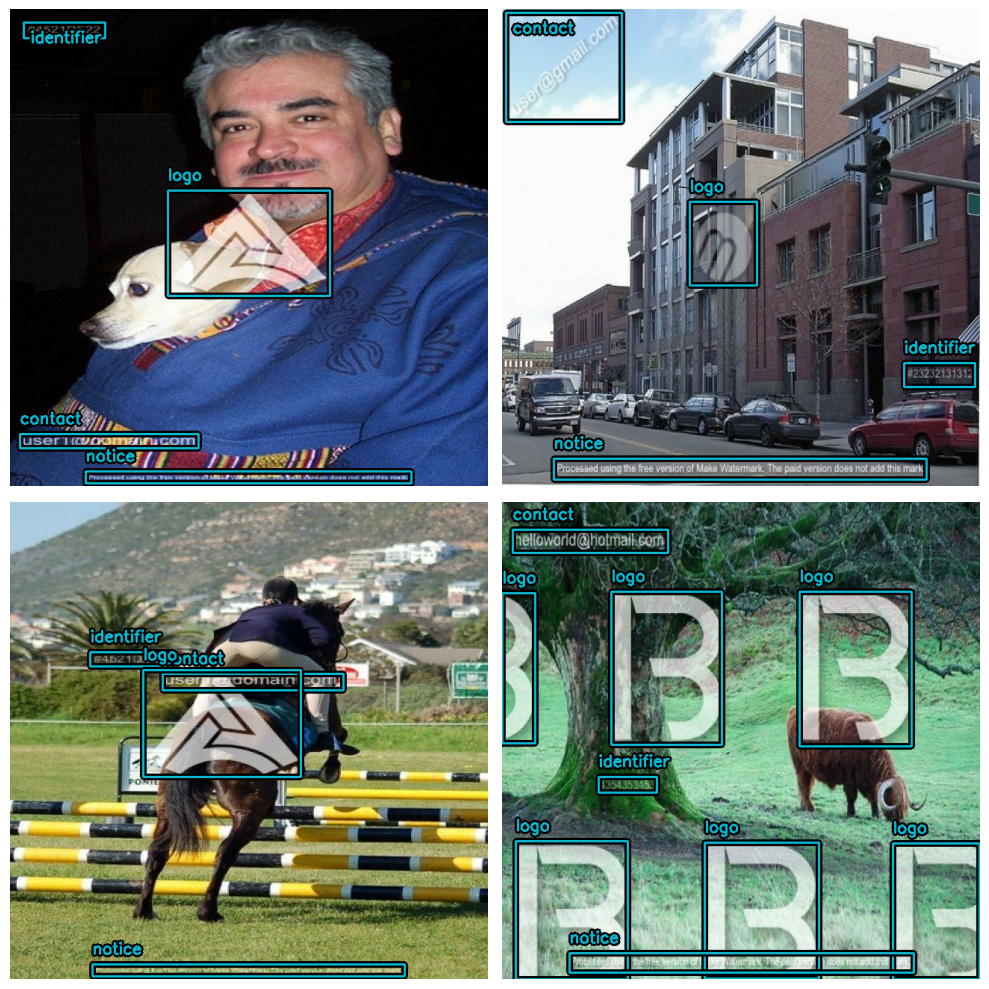

In [3]:
# visualize the training split.

print("TRAINING DATA")
visualize_dataset(
    train,
    data_loader.class_mapping,
    bounding_box_format=BOUNDING_BOX_FORMAT, 
    value_range=(0, 255), rows=2, cols=2, 
)

print("VALIDATION DATA")
visualize_dataset(
    val,
    data_loader.class_mapping,
    bounding_box_format=BOUNDING_BOX_FORMAT,
    value_range=(0, 255),
    rows=2,
    cols=2,
)

The Keras object detection pipeline requires the dataset to be in a specific format.  When loading the dataset, we used the following structure:

```python
{
    "images": Tensor(),
    "bounding_boxes": {
        "classes": Tensor(),
        "boxes": RaggedTensor()
    }
}
```

The bounding box format needs to be translated from a python dictionary to dense bounding box tensors and this is done using the dataset `map` function.

```python
{
    "images": Tensor(),
    "bounding_boxes": DenseTensor()
}
```

In [4]:
def dict_to_tuple(inputs):
    return inputs["images"], keras_cv.bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=30
    )


train_ds = train.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)

The code below loads the pre-trained YOLOv8 detector using the `resnet50_imagenet` weights.

The Keras CV documentation suggests using a custom NonMaxSupression prediction decoder because custom values are often required for custom object detection tasks.  The values for the decoder will need to be fine-tuned later in the project.

In [5]:
model = keras_cv.models.YOLOV8Detector.from_preset(
    "resnet50_imagenet",    # image classifier pre-trained on imagenet.
    bounding_box_format=BOUNDING_BOX_FORMAT,
    num_classes=len(CLASS_IDS),
    prediction_decoder=keras_cv.layers.NonMaxSuppression(
        bounding_box_format=BOUNDING_BOX_FORMAT,
        from_logits=True,   # experiment with different values.
        iou_threshold=0.2,
        confidence_threshold=0.4,
        max_detections=20
    )
)

model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
    optimizer=keras.optimizers.SGD(learning_rate=0.0025, momentum=0.9, global_clipnorm=10.0),
    box_loss_weight=10.0,
    classification_loss_weight=3.0
)

## Train the YOLOv8 model using custom watermark dataset

The code below leverages functions available in the Keras computer vision library to help visualize model predictions so that they can be evaluated visually after each epoch.  This helps to understand the progress and give a visual representation of the mapping between detections and COCO metrics used when training the model.

Note: The model doesn't show very good accuracy at this stage, and doesn't have to.  With the successful training of the model, we can validate that the entire workflow (watermarking, annotation, loading and processing) works to format the data as required to train the model.

In [ ]:
def visualize_detections(model, dataset, bounding_box_format, class_mapping):
    """ Used to plot detections from the YOLOv8 model.
    Reference: https://keras.io/examples/vision/yolov8/
    """
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


class VisualizeDetections(keras.callbacks.Callback):
    """Used to visualize detection progress after each epoch.
    Reference: https://keras.io/examples/vision/yolov8/
    """
    def on_epoch_end(self, epoch, logs):
        visualize_detections(
            self.model,
            bounding_box_format=BOUNDING_BOX_FORMAT,
            dataset=val_ds,
            class_mapping=data_loader.class_mapping,
        )

# Train the YOLOv8 model using custom watermark image dataset.
model.fit(
    train_ds,  # loop if end of dataset is reached due to small intial dataset.
    validation_data=val_ds,
    epochs=50,  # early stopping callback may mean this is never reached.
    callbacks=[
        keras_cv.callbacks.PyCOCOCallback(  # COCO metrics (AP/AR @ IOU)
            test_ds, bounding_box_format=BOUNDING_BOX_FORMAT
        ),
        keras.callbacks.TensorBoard(  # training progress visualization
            log_dir="training_logs"
        ),
        keras.callbacks.ModelCheckpoint(  # save best model
            filepath="./model_checkpoints/best_model.keras",
            monitor="box_loss",
            mode="min",
            save_best_only=True,
        ),
        keras.callbacks.EarlyStopping(  # stop if not improving
            monitor="box_loss",
            patience=3,
            mode="max",
            restore_best_weights=True,
            verbose=1
        ),
        # VisualizeDetections(),  # visual validation after each epoch for debugging
    ],
    verbose=0,  # suppress epoch output since monitoring in TensorBoard.
)

/home/gb/FinalProject/prototype/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(4, 640, 640, 3))
  warnings.warn(msg)
I0000 00:00:1737224389.838834  160439 service.cc:148] XLA service 0x7f05bc002310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737224389.838922  160439 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2080, Compute Capability 7.5
2025-01-18 13:19:50.945624: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737224392.919551  160439 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-18 13:19:55.378442: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.20GiB w

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | ar

2025-01-18 13:21:03.101524: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 |

2025-01-18 13:21:14.339575: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 |

2025-01-18 13:21:26.308054: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 |

## Final visualization on test data

After the model has been fine-tuned with the custom training and validation data, it is essential to evaluate the models ability to generalize to unseen data.  To do this we need to use the test set, since it was not used during the training process. (Simple hold off.)

This method may be evolved as-needed throughout the project to improve the accuracy of the detector.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


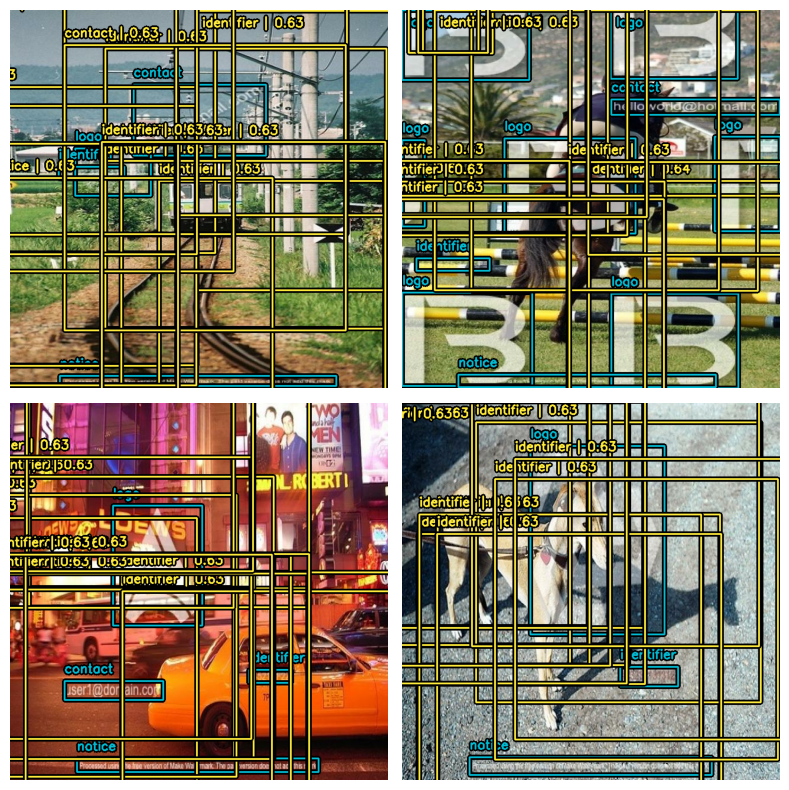

In [7]:
visualize_detections(
    model,   # can use model because restored to best weights.
    dataset=test_ds,
    bounding_box_format=BOUNDING_BOX_FORMAT,
    class_mapping=data_loader.class_mapping,
)

# References

[1] Team, Keras. “Keras Documentation: Efficient Object Detection with YOLOV8 and KerasCV.” Keras.io, keras.io/examples/vision/yolov8/.


[2] K. Team, “Keras documentation: Keras API reference,” keras.io. https://keras.io/api/
‌